## Build test data

We'll use a star with a clear sinusoidal signal and multiple sectors for complete coverage on the different data types for targets that require TPF content.

We'll also generate a clear and a failure mode synthetic light curve for testing the detection methods.

We'll choose a single-sector star for download testing.

In [1]:
from fleck import generate_spots, Star
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [2]:
np.random.seed(802)
N = 2
spot_contrast = np.random.uniform(0.5, 1., size=N)
rotation_period = np.random.uniform(1.5, 27., size=N)/5
u_ld = [0.5, 0.2]

spot_radius = np.random.uniform(0.05, 0.15, size=N)
min_latitude = np.random.uniform(30, 60, size=N)
max_latitude = np.random.uniform(61, 85, size=N)

t = np.arange(0, 27., 0.02)
yerr = 1e-6*np.array([5000, 100])

n_phases = len(t)
n_inclinations = 1
n_spots = np.random.uniform(10, 30, size=N).astype(int)

In [3]:
np.random.seed(802)

sim = np.zeros((N, len(t)))
obs = np.zeros((N, len(t)))

for idx in range(N):
    lons, lats, radii, inc_stellar = generate_spots(min_latitude[idx], max_latitude[idx],
                                                   spot_radius[idx], n_spots[idx],
                                                   n_inclinations=n_inclinations)
    star = Star(spot_contrast = spot_contrast[idx], n_phases=n_phases, 
                u_ld = u_ld, rotation_period = rotation_period[idx])
    lc = star.light_curve(lons, lats, radii, inc_stellar, times=t)
    
    lc -= np.mean(lc)
    lc += 1.
    
    sim[idx, :] = lc.flatten()
    obs[idx, :] = lc.flatten() + yerr[idx] * np.random.randn(len(t))


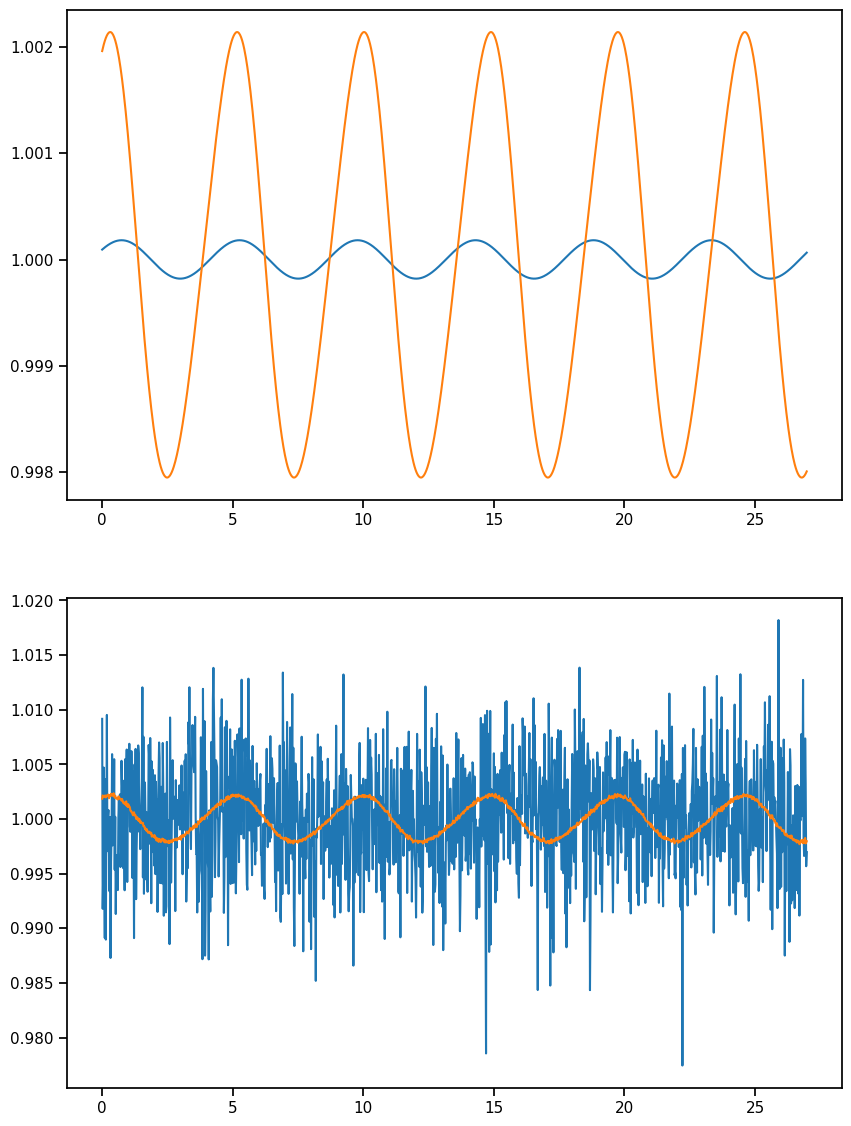

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10, 14))
ax[0].plot(t, sim.T)
ax[1].plot(t, obs.T)
plt.show()

In [97]:
from astropy import units as u
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from michael.utils import _gaussian_fn, _safety
from tqdm import tqdm

peaks = [1]
for seed in tqdm(range(1000)):
    np.random.seed(seed)
    failure = np.random.randn(len(t))*500 + 1.

    sector = 0 

    # Call the relevant light curve
    period_range = (0.1, 27)
    clc = lk.LightCurve(t, failure)

    pg = clc.to_periodogram(minimum_period = period_range[0], maximum_period = period_range[1], normalization='psd', oversample_factor=100,
                                freq_unit = 1/u.day)

    # Select the region around the highest peak
    max_period = pg.period_at_max_power.value
    max_power = pg.max_power.value
    s = (pg.period.value > 0.6*max_period) & (pg.period.value < 1.4*max_period)
    p = pg[s].period.value
    P = pg[s].power.value

    # Store the periodogram for plotting
    j.void[f'pg_{sector}'] = pg
    j.void[f'p_{sector}'] = p
    j.void[f'P_{sector}'] = P

    # Fit a Gaussian
    ## Params are mu, sigma, Amplitude
    lolim = 0.8*max_period
    if lolim < period_range[0]:
        lolim = period_range[0]
    uplim = 1.2*max_period
    if uplim > period_range[1]:
        uplim = period_range[1]

    popt, pcov = curve_fit(_gaussian_fn, p, P, p0 = [max_period, 0.1*max_period, max_power],
                            bounds = ([lolim, 0., 0.9*max_power],[uplim, 0.25*max_period, 1.1*max_power]))

    j.results.loc[sector, 'SLS'] = popt[0]
    j.results.loc[sector, 'e_SLS'] = popt[1]
    j.results.loc[sector, 'h_SLS'] = popt[2]
    j.results.loc[sector, 'f_SLS'] = 0

    peaks, _ = find_peaks(pg.power.value, height = 0.9*max_power)
    if len(peaks) > 1:
        j.results.loc[sector, 'f_SLS'] += 3

        # Double check if the presence of a second peak has upset the fits
        # If so, repeat the fit in a smaller range
        peaks, _ = find_peaks(P, height=0.9*max_power)
        if len(peaks) > 1:
            sig_rms = np.sqrt(np.mean((clc.flux.value - 1)**2))
            sig_ps = 4 * sig_rms**2 / len(clc)
            if popt[2] < 4 * sig_ps:
                break

plt.plot(t, failure)
plt.show()  
ax = pg.plot()
ax.axhline(0.9*max_power)
for peak in peaks:
    ax.axvline(p[peak])
plt.show()    
print(f"break at seed {seed}")

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/Users/Anaconda/anaconda3/envs/michael/lib/python3.10/site-packages/lightkurve/lightcurve.py:277: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(
 53%|█████████████████████                   | 528/1000 [00:26<00:23, 20.21it/s]


KeyboardInterrupt: 

In [98]:
from michael.methods import simple_astropy_lombscargle
import lightkurve
import lightkurve as lk
import glob
from michael import janet
j = janet('synthetic', 0., 0., output_path = 'tests/data')
j.sectors = ['0']
j.sectorlist = ['0']

np.random.seed(5)
failure = np.random.randn(len(t))*0.1 + 1

j.void['clc_0']  = lk.LightCurve(t, failure)

# Call function and assert outcomes
simple_astropy_lombscargle(j, 0, period_range = (0.1, 27))

# Check periodogram have been saved
assert type(j.void['pg_0']) == lightkurve.periodogram.LombScarglePeriodogram
assert type(j.void['p_0']) == np.ndarray
assert type(j.void['P_0']) == np.ndarray
assert type(j.void['popt_0']) == np.ndarray

# Check results have been stored correctly
assert len(j.results.loc[0]) == 4
assert all(np.isfinite(j.results.loc[0]))


### Running Simple Astropy Lomb-Scargle on Sector 0 on star synthetic ###
### Completed Simple Astropy Lomb-Scargle for Sector 0 on star synthetic ###


In [99]:
j.results

,SLS,e_SLS,h_SLS,f_SLS
0,0.246206,0.001002,0.002256,3.0


In [24]:
j.void['pg_0'].show_properties()

lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
          default_view                            period      
             ls_method                              fast      
frequency_at_max_power                            1.8284 1 / d
             max_power                            0.0006     d
               nyquist                              25.0 1 / d
   period_at_max_power                            0.5469     d
             frequency                    array (26881,) 1 / d
                period                    array (26881,)     d
                 power                    array (26881,)     d
                 label                <class 'NoneType'>      
                  meta <class 'collections.OrderedDict'>      
              targetid                <class 'NoneType'>      


In [ ]:
for l in list(j.void):
    print(type(j.void[l]))

In [ ]:
j.results

In [ ]:
list(j.void)

In [ ]:
sys.exit()

In [ ]:
rotation_period

In [ ]:
types = ['failure', 'pass']

for i in range(N):
    fname = f'tests/data/synthetic_{rotation_period[i]:.2f}_{types[i]}.txt'
    np.savetxt(fname, obs[i])

## Now let's check a simple double sector case for eleanor to test on

In [ ]:
gaiaid = 4984094970441940864
ra = 20.457083
dec = -42.022861

In [ ]:
from michael import janet

In [ ]:
j = janet(gaiaid, ra, dec, output_path = 'tests/data')

In [ ]:
# j.run()

In [ ]:
j.prepare_data()

In [ ]:
j.data.build_unpopular_lc()

In [ ]:
list(j.void)

In [ ]:
j.sectorlist

In [ ]:
import glob
import lightkurve as lk
import tess_cpm
from astropy.coordinates import SkyCoord
import astropy.units as u
rastr = str(j.ra)
step = len(rastr.split('.')[0])
decstr = str(j.dec)
step = len(decstr.split('.')[0])
sfiles = np.sort(glob.glob(f'/Users/oliver hall/.eleanor/tesscut/*{rastr[:(6+step)]}*{decstr[:(6+step)]}*'))
coords = SkyCoord(ra = j.ra, dec = j.dec, unit = (u.deg, u.deg))

# Set up a standard aperture based on the `eleanor` aperture for a 50x50
# postcard.
for sfile, s in zip(sfiles, j.sectorlist):
    cpm = tess_cpm.Source(sfile, remove_bad=True)
    aperture = j.void[f'datum_{s}'].aperture
    rowlims = 20 + np.array([np.where(aperture)[0].min(), np.where(aperture)[0].max()])
    collims = 20 + np.array([np.where(aperture)[1].min(), np.where(aperture)[1].max()])
    cpm.set_aperture(rowlims = rowlims, collims = collims)

    # We use 200 predictors for a stamp of this size. This is a rough
    # guesstimate from trial-and-error, but seems to work well.
    cpm.add_cpm_model(exclusion_size=6, n=200,
        predictor_method = "similar_brightness")
    cpm.set_regs([0.1])
    cpm.holdout_fit_predict(k=100, verbose=False)

    # Save corrected flux as a lightcurve object for this sector
    flux = cpm.get_aperture_lc(data_type="cpm_subtracted_flux",
                                weighting='median')
    self.j.void[f'cpmlc_{s}'] = lk.LightCurve(time = cpm.time, flux = flux) + 1.
    self.j.void[f'cpm_{s}'] = cpm

In [ ]:
import sys
import pytest
import os
import shutil

sys.path.append('../')

import numpy as np
from numpy.testing import assert_almost_equal, assert_array_equal
from michael import janet
from michael.data import data_class
import astropy.units as u
import glob
import lightkurve
# Using a known rotator from the Gaia catalogue
gaiaid = 4984094970441940864
ra = 20.457083
dec = -42.022861

j = janet(gaiaid, ra, dec, output_path = 'tests/data')
data = data_class(j)
data.check_eleanor_setup()

# Assert tess-sip generates lightkurve LightCurve object
data.build_tess_sip_lc()
for s in list(j.sectors):
    assert f'r_{s}' in list(j.void)
    assert f'rlc_{s}' in list(j.void)
    assert type(j.void[f'rlc_{s}']) == lightkurve.lightcurve

In [ ]:
type(j.void[f'rlc_{s}'])

In [ ]:
assert type(j.void[f'rlc_{s}']) == lightkurve.lightcurve.TessLightCurve

In [ ]:
data.check_eleanor_setup()

In [ ]:
data.build_eleanor_lc()

In [ ]:
list(j.void)

In [ ]:
data.build_unpopular_lc()

In [ ]:
list(j.void)

In [ ]:
    for s in j.sectorlist:
        assert f'cpm_{s}' in list(j.void)
    for s in list(j.sectors) + list(j.sectorlist):
        assert f'cpmlc_{s}' in list(j.void)
        assert type(j.void[f'cpmlc_{s}']) == lightkurve.LightCurve
